In [1]:
import numpy as np
import qutip as qt

import numpy as np
from qutip import Options
import qutip as qt
from qutip import ket2dm
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
import matplotlib.pyplot as plt
from itertools import product
from qutip.qip.operations import iswap
from tqdm.notebook import tqdm
import cmath
from scipy.optimize import curve_fit

In [2]:
qubit_dim = 2

w1_un = 4
w2_un = 6
w3_un = 4.6666666666666666
ws_un = 5.6666666666666666


qubit1 = QubitMode(
    name="q1", dim=2, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    name="q2", dim=2, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    name="q3", dim=2, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [3]:
# parameter declaration
# declaring the hybridization values and ensuring that they are kept at .1
# g1 = .1 * np.abs(ws_un - w1_un)
# g2 = .1 * np.abs(ws_un - w2_un)
# g3 = .1 * np.abs(ws_un - w3_un)
# g4 = .1 * np.abs(ws_un - w4_un)

# l1 = g1 / np.abs(ws_un - w1_un)
# l2 = g2 / np.abs(ws_un - w2_un)
# l3 = g3 / np.abs(ws_un - w3_un)
# l4 = g4 / np.abs(ws_un - w4_un)

l1 = l2 = l3 = .1

w1 = w1_un 
w2 = w2_un 
w3 = w3_un 
ws = ws_un 

# time over which to optimize
T = 100

#pump(drive) frequency
wp = np.abs(w1 - w2)

In [4]:
# creating the hamiltonian 
H_no_time = 6*(l1**2)*(qs.modes_a[qubit1]*qs.modes_a_dag[qubit2] + qs.modes_a[qubit2]*qs.modes_a_dag[qubit1])

#terms that come from the gate that is desired that do not go to zero 
qubit1_qubit2_adj_H = 6*(l1**2)*qs.modes_a[qubit1]*qs.modes_a_dag[qubit2]
qubit1_adj_qubit2_H = 6*(l1**2)*qs.modes_a[qubit2]*qs.modes_a_dag[qubit1]

# disruptive term over which to analyze the behavior 
# the snail qubit terms that are in this hamiltonian 
snail_qubit1_H = 6*(l1)*qs.modes_a[snail]*qs.modes_a_dag[qubit1]
snail_qubit3_H = 6*(l1)*qs.modes_a[snail]*qs.modes_a_dag[qubit3]
snail_adj_qubit1_H = 6*(l1)*qs.modes_a[qubit1]*qs.modes_a_dag[snail]
snail_ajd_qubit3_H = 6*(l1)*qs.modes_a[qubit3]*qs.modes_a_dag[snail]
snail_qubit2_H = 6*(l1)*qs.modes_a[snail]*qs.modes_a_dag[qubit2]
snail_ajd_qubit2_H = 6*(l1)*qs.modes_a[qubit2]*qs.modes_a_dag[snail]

# creating the hamiltonian list 
H = [H_no_time,
qubit1_qubit2_adj_H,
qubit1_adj_qubit2_H,
snail_qubit1_H,
snail_qubit3_H,
snail_adj_qubit1_H,
snail_ajd_qubit3_H,
snail_qubit2_H,
snail_ajd_qubit2_H] 

In [5]:
#create the time coefficients of all of these hamiltonian parts 
#write in the evaluated functions and find the values before multiplying to a matrix
def int_func(w1,w2,wp,t):
    a=((np.exp(-1j*(w1-w2+wp)*t))/(-1j*(w1-w2+wp)) - (1/(-1j*(w1-w2+wp))))
    return a

def int_func_conj_wp(w1,w2,wp,t):
     a = ((np.exp(-1j*(w1-w2-wp)*t))/(-1j*(w1-w2-wp)) - (1/(-1j*(w1-w2-wp))))
     return a

def int_func_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2+wp)*t))/(1j*(w1-w2+wp)) - (1/(1j*(w1-w2+wp))))
    return a 

def int_func_conj_wp_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2-wp)*t))/(1j*(w1-w2-wp)) - (1/(1j*(w1-w2-wp))))
    return a

# qubit1_qubit2_adj_val = int_func(w1,w2,wp,T)
# qubit1_adj_qubit2_val = int_func_conj(w1,w2,wp,T)
snail_qubit1_val = int_func(ws,w1,wp,T) + int_func_conj_wp(ws,w1,wp,T)
snail_qubit3_val = int_func(ws,w3,wp,T) + int_func_conj_wp(ws,w3,wp,T)
snail_adj_qubit1_val = int_func(w1,ws,wp,T) + int_func_conj_wp(w1,ws,wp,T)
snail_ajd_qubit3_val = int_func(w3,ws,wp,T) + int_func_conj_wp(w3,ws,wp,T) 
snail_qubit2_val = int_func(ws,w2,wp,T) + int_func_conj_wp(ws,w2,wp,T)
snail_ajd_qubit2_val = int_func(w2,ws,wp,T) + int_func_conj_wp(w2,ws,wp,T)

In [6]:
# #create the target iswap gate
# U_targ = U = qt.tensor(qt.qip.operations.iswap(N=2),qt.qeye(2),qt.identity(cavity.dim))
desired_U = iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
for mode in qs.modes[2:]:  # Skip the first two qubits as they're already included
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2


In [7]:
#optimize over the amplitude to find the highest fidelity 
amps = np.linspace(0,8,100)
freq = np.linspace(4.00000001,5.999999999,300)
w3 = 4.666666666666
amps_freq = [(i,j) for i in freq for j in amps]
Z = []
results = []

for i in range(len(amps_freq)):
    eta = ((2 * wp) / ((wp**2) - ((amps_freq[i][0])**2))) * amps_freq[i][1]
    for j in range(len(H)):

        # qubit1_qubit2_adj_val = int_func(w1,w2,wp,T)
        # qubit1_adj_qubit2_val = int_func_conj(w1,w2,wp,T)
        qubit1_qubit2_adj_val = int_func_conj_wp(w1,w2,wp,T)
        qubit1_adj_qubit2_val = int_func_conj_wp_conj(w1,w2,wp,T)
        snail_qubit1_val = int_func(amps_freq[i][0],w1,wp,T) + int_func_conj_wp(amps_freq[i][0],w1,wp,T)
        snail_qubit3_val = int_func(amps_freq[i][0],w3,wp,T) + int_func_conj_wp(amps_freq[i][0],w3,wp,T)
        snail_adj_qubit1_val = int_func(w1,amps_freq[i][0],wp,T) + int_func_conj_wp(w1,amps_freq[i][0],wp,T)
        snail_ajd_qubit3_val = int_func(w3,amps_freq[i][0],wp,T) + int_func_conj_wp(w3,amps_freq[i][0],wp,T)
        snail_qubit2_val = int_func(amps_freq[i][0],w2,wp,T) + int_func_conj_wp(amps_freq[i][0],w2,wp,T)
        snail_ajd_qubit2_val = int_func(w2,amps_freq[i][0],wp,T) + int_func_conj_wp(w2,amps_freq[i][0],wp,T)

        time_multiplier = [T, qubit1_qubit2_adj_val, qubit1_adj_qubit2_val, snail_qubit1_val, snail_qubit3_val, snail_adj_qubit1_val, 
                   snail_ajd_qubit3_val, snail_qubit2_val, snail_ajd_qubit2_val]

        Z.append(eta * H[j] * time_multiplier[j])

    W = sum(Z)

    U_propagator = (-1j * W).expm()

    #calculate the fidelity
    fid = np.abs(qt.average_gate_fidelity(desired_U, U_propagator))
    results.append([amps_freq[i][0],amps_freq[i][1],fid])

    #clearing the list for the next iteration
    Z.clear()

In [8]:
sep_w1_ws = []
sep_w2_ws = []
sep_w3_ws = []


In [9]:
#take the results from the cell above and find what max fidelity at a set frequency is 
#don't really care about the amplitude but needed to sweep over it 
freqs_snail = []
fids_snail = []


for i in range(len(freq)):
    max_fid_freq = 0.0   
    for j in range(len(amps)):
        # want the max fidelity from each frequency 
        if max_fid_freq < results[(100 * i) + j][2]:
            max_fid_freq = results[(100 * i) + j][2]

    sep_w1_ws.append(np.abs(w1 - results[(100 * i) + j][0]))
    sep_w2_ws.append(np.abs(w2 - results[(100 * i) + j][0]))
    sep_w3_ws.append(np.abs(w3 - results[(100 * i) + j][0]))
    
    #making the set of frequencies and the max fid achieved at said frequency
    freqs_snail.append(results[(100 * i) + j][0])
    fids_snail.append(max_fid_freq)   



In [10]:
max(fids_snail)

0.8629610198689733

In [11]:
#finding the separations that actually need to be plotted
# under trail(not yet useful)
gate_sep_wp_snails_w1 = []
gate_sep_wp_snails_w2 = []
gate_sep_wp_snails_w3 = []
min_seps_gates = []


for i in range(len(sep_w1_ws)):
    min_gate_sep = 2.0
    gate_sep_wp_snails_w1.append(np.abs(np.abs(wp) - sep_w1_ws[i]))
    gate_sep_wp_snails_w2.append(np.abs(np.abs(wp) - sep_w2_ws[i]))
    gate_sep_wp_snails_w3.append(np.abs(np.abs(wp) - sep_w3_ws[i]))

# for i in range(len(gate_sep_wp_snail_w1)):
    if min_gate_sep > gate_sep_wp_snails_w1[i]:
        min_gate_sep = gate_sep_wp_snails_w1[i]
    if min_gate_sep > gate_sep_wp_snails_w2[i]:
        min_gate_sep = gate_sep_wp_snails_w2[i]
    if min_gate_sep > gate_sep_wp_snails_w3[i]:
        min_gate_sep = gate_sep_wp_snails_w3[i]
    
    min_seps_gates.append(min_gate_sep)


Text(0, 0.5, 'Fidelity')

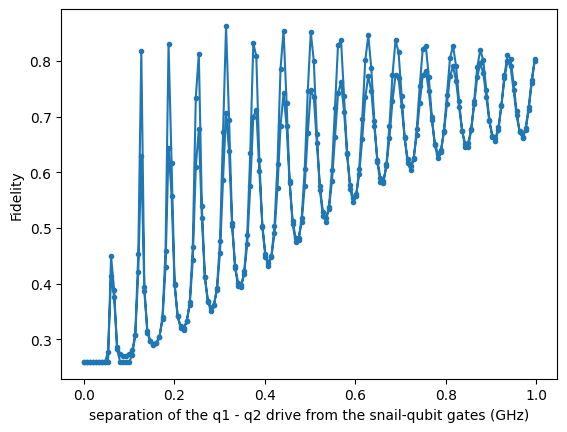

In [12]:
fig, ax = plt.subplots()
ax.plot(min_seps_gates, fids_snail, marker = '.')
ax.set_xlabel('separation of the q1 - q2 drive from the snail-qubit gates (GHz)')
ax.set_ylabel('Fidelity')